# Mount Data

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Start

In [0]:
import numpy as np
import math
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as Data
from torchsummary import summary
from torchvision import transforms
from scipy import ndimage as nd
from matplotlib.patches import ConnectionPatch
import heapq

left_path = "./drive/My Drive/csc420/a4/000020_left.jpg"
right_path = "./drive/My Drive/csc420/a4/000020_right.jpg"
I1_path = "./drive/My Drive/csc420/a4/I1.jpg"
I2_path = "./drive/My Drive/csc420/a4/I2.jpg"
I3_path = "./drive/My Drive/csc420/a4/I3.jpg"

left_car_box_path = "./drive/My Drive/csc420/a4/000020.txt"
camera_features_path = "./drive/My Drive/csc420/a4/000020_allcalib.txt"

left_car_box = open(left_car_box_path, "r")
left_car_box_list = left_car_box.readline().split(" ")[1:]
left_car_top_left = (float(left_car_box_list[0]), float(left_car_box_list[1]))
left_car_bottom_right = (float(left_car_box_list[2]), float(left_car_box_list[3]))

camera_features = open(camera_features_path, "r")
camera_features_list = camera_features.readlines()
f = float(camera_features_list[0].split(" ")[1])
px = float(camera_features_list[1].split(" ")[1])
py = float(camera_features_list[2].split(" ")[1])
baseline = float(camera_features_list[3].split(" ")[1])

left_img = cv2.imread(left_path)
left_img_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
left_img_float = left_img.astype(np.float64)
left_img_gray_float = left_img_gray.astype(np.float64)

right_img = cv2.imread(right_path)
right_img_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
right_img_float = right_img.astype(np.float64)
right_img_gray_float = right_img_gray.astype(np.float64)

I1_img = cv2.imread(I1_path, cv2.IMREAD_COLOR)
I1_img = cv2.cvtColor(I1_img, cv2.COLOR_BGR2RGB)
I1_img_gray = cv2.cvtColor(I1_img, cv2.COLOR_BGR2GRAY)
I1_img_float = I1_img.astype(np.float64)
I1_img_gray_float = I1_img_gray.astype(np.float64)

I2_img = cv2.imread(I2_path, cv2.IMREAD_COLOR)
I2_img = cv2.cvtColor(I2_img, cv2.COLOR_BGR2RGB)
I2_img_gray = cv2.cvtColor(I2_img, cv2.COLOR_BGR2GRAY)
I2_img_float = I2_img.astype(np.float64)
I2_img_gray_float = I2_img_gray.astype(np.float64)

I3_img = cv2.imread(I3_path, cv2.IMREAD_COLOR)
I3_img = cv2.cvtColor(I3_img, cv2.COLOR_BGR2RGB)
I3_img_gray = cv2.cvtColor(I3_img, cv2.COLOR_BGR2GRAY)
I3_img_float = I3_img.astype(np.float64)
I3_img_gray_float = I3_img_gray.astype(np.float64)

I1_img_resized = cv2.resize(I1_img, (int(0.5*I1_img.shape[1]),int(0.5*I1_img.shape[0])))
I2_img_resized = cv2.resize(I2_img, (int(0.5*I2_img.shape[1]),int(0.5*I2_img.shape[0])))
I1_img_resized_3 = cv2.resize(I1_img, (int(0.2*I1_img.shape[1]),int(0.2*I1_img.shape[0])))
I3_img_resized = cv2.resize(I3_img, (int(0.2*I3_img.shape[1]),int(0.2*I3_img.shape[0])))

# Helper

In [0]:
def depth(f, baseline, disparity):
    Z = (f * baseline) / disparity
    return Z

def get_car(car, top_left, bottom_right):
    x0 = int(top_left[0])
    x1 = int(bottom_right[0])
    y0 = int(top_left[1])
    y1 = int(bottom_right[1])
    cropped = car[y0:y1, x0:x1]
    top_left = (y0, x0)
    bottom_right = (y1, x1)
    return cropped, top_left, bottom_right

# NC

In [0]:
def nc(patch_l, patch_r):
    product = np.sum(patch_l * patch_r)
    norm_l = np.sum(patch_l ** 2)
    norm_r = np.sum(patch_r ** 2)
    numerator = product
    denominator = np.sqrt(norm_l * norm_r)
    return numerator / denominator

# Stereo Match

In [0]:
def stereo_match(left_img, right_img, patch_size, box_top_left, box_bottom_right):

    car, top_left, bottom_right = get_car(left_img, box_top_left, box_bottom_right)

    result = np.copy(car)
    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    x0 = top_left[1]
    y0 = top_left[0]
    x1 = bottom_right[1]
    y1 = bottom_right[0]

    patch_center = top_left
    scanline = y0
    right_row = right_img.shape[0]
    right_col = right_img.shape[1]

    d = 0
    dy = 0
    dx = 0

    for y in range(y0, y1):
        print(".", end="", flush=True)

        for x_left in range(x0, x1):

            patch_left_center = (y, x_left)
            patch_left_x0 = x_left - math.floor(patch_size / 2)
            patch_left_y0 = y - math.floor(patch_size / 2)
            patch_left_x1 = x_left + math.ceil(patch_size / 2)
            patch_left_y1 = y + math.ceil(patch_size / 2)

            patch_left = np.copy(left_img[patch_left_y0:patch_left_y1, patch_left_x0:patch_left_x1])
            patch_right_best = np.zeros([patch_left_y1 - patch_left_y0, patch_left_x1 - patch_left_x0])
            nc_best = 0
            x_right_best = 0

            for x_right in range(math.floor(patch_size / 2), x_left):

                patch_right_center = (y, x_right)
                patch_right_x0 = x_right - math.floor(patch_size / 2)
                patch_right_y0 = y - math.floor(patch_size / 2)
                patch_right_x1 = x_right + math.ceil(patch_size / 2)
                patch_right_y1 = y + math.ceil(patch_size / 2)

                patch_right = np.copy(right_img[patch_right_y0:patch_right_y1, patch_right_x0:patch_right_x1])
                nc_value = nc(patch_left, patch_right)

                if nc_value > 1000:
                    continue
                if nc_value > nc_best:
                    nc_best = nc_value
                    patch_right_best = patch_right
                    x_right_best = x_right

            # print("nc_best = ", nc_best)
            # print("patch right = ", patch_right_best)
            disparity = x_left - x_right_best
            # print("x_left = ", x_left)
            # print("x_right_best = ", x_right_best)
            # print("disparity = ", disparity)
            d = depth(f, baseline, disparity)
            # print("depth = ", d)
            # print("==========================================================")

            result[dy, dx] = d
            dx += 1
        dy += 1
        dx = 0

    plt.imshow(result)
    return result

# TEST

.............................................................................

array([[34.94288544, 34.94288544, 34.94288544, ..., 12.01161687,
        11.64762848, 11.30505117],
       [34.94288544, 34.94288544, 34.94288544, ..., 12.01161687,
        11.64762848, 11.30505117],
       [34.94288544, 34.94288544, 34.94288544, ..., 12.01161687,
        11.64762848, 11.30505117],
       ...,
       [14.78352846, 14.78352846, 14.78352846, ..., 14.78352846,
        14.78352846, 14.23599037],
       [14.78352846, 13.25419793, 13.25419793, ..., 14.78352846,
        14.78352846, 14.23599037],
       [13.72756214, 14.23599037, 13.72756214, ..., 14.23599037,
        14.23599037, 14.23599037]])

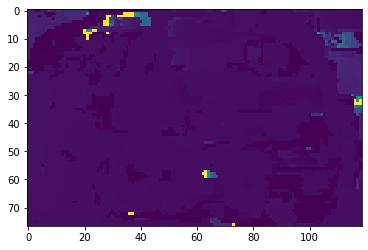

In [0]:
stereo_match(left_img_gray_float, right_img_gray_float, 7, left_car_top_left, left_car_bottom_right)

# Q2.b

# Import

In [6]:
%cd "drive"
%cd "My Drive"
%cd "csc420"
%cd "a4"
%cd "GANet"
!chmod 777 ./compile.sh
!./compile.sh

/content/drive
/content/drive/My Drive
/content/drive/My Drive/csc420
/content/drive/My Drive/csc420/a4
/content/drive/My Drive/csc420/a4/GANet
running clean
removing 'build/temp.linux-x86_64-3.6' (and everything under it)
running build
running build_ext
building 'GANet' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/src
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/include/TH -I/usr/local/lib/python3.6/dist-packages/torch/include/THC -I/usr/local/cuda/include -I/usr/include/python3.6m -c src/GANet_cuda.cpp -o build/temp.linux-x86_64-3.6/src/GANet_cuda.o -DTORCH_API_INCLUDE_EXTENSION_H -DTORCH_EXTENSION_NAME=GANet -D_GLIBCXX_USE_CXX11_ABI=0 -std=c

In [0]:
import models.GANet_deep as GANet

In [8]:
%cd ..
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/My Drive/csc420/a4
/content/drive/My Drive/csc420
/content/drive/My Drive
/content/drive
/content


In [9]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
net = nn.DataParallel(GANet.GANet())
net.load_state_dict(torch.load("./drive/My Drive/csc420/a4/kitti2015_final.pth")["state_dict"])

<All keys matched successfully>

# Generate

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

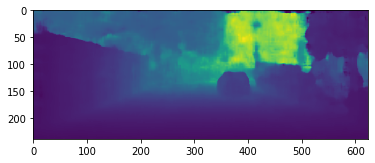

In [10]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((240, 624)), 
                                transforms.ToTensor()])
left_img_transformed = transform(left_img).reshape(1,3,240,624)
right_img_transformed = transform(right_img).reshape(1,3,240,624)

disparity, _, _ = net(left_img_transformed, right_img_transformed)
disparity_narray = disparity.cpu().detach().numpy()[0]
depth = f * baseline / disparity_narray

plt.imshow(depth)

# Q2.d

# Resize

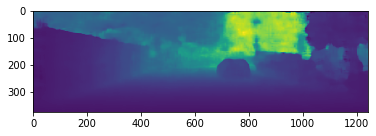

In [12]:
resized_result = cv2.resize(depth, (1242,375), interpolation = cv2.INTER_CUBIC)
plt.imshow(resized_result)

# 2D Box

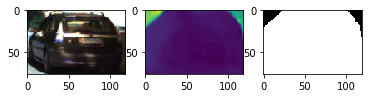

In [20]:
car, top_left, bottom_right = get_car(left_img, left_car_top_left, left_car_bottom_right)
plt.subplot(1,3,1)
plt.imshow(car)

car_depth, top_left, bottom_right = get_car(resized_result, left_car_top_left, left_car_bottom_right)
plt.subplot(1,3,2)
plt.imshow(car_depth)

ret, binary_mask = cv2.threshold(car_depth,50,1,0)
plt.subplot(1,3,3)
plt.imshow(binary_mask,cmap=plt.cm.binary)

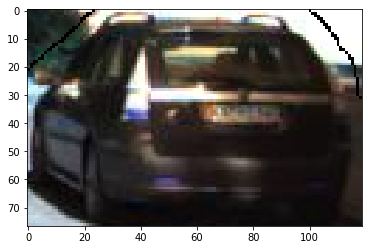

In [19]:
output = np.array(binary_mask)*255
result = np.copy(car)
output_canny = cv2.Canny(np.uint8(output), 20, 250)
result[output_canny == 255] = [0,1,0]
plt.imshow(result)

top_left =  (181, 685)
bottom_right =  (258, 804)


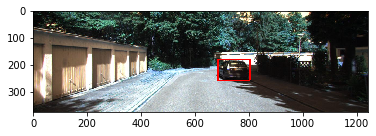

In [0]:
draw_2D_box = np.copy(left_img)
print("top_left = ", top_left)
print("bottom_right = ", bottom_right)
draw_2D_box = cv2.rectangle(draw_2D_box, (top_left[1], top_left[0]), (bottom_right[1], bottom_right[0]), (255,0,0), 4)
plt.imshow(draw_2D_box)

# 3D Box

In [0]:
def draw_3D_box(depth_img, original_img, box_top_left, box_bottom_right, threshold):
    car_depth, top_left, bottom_right = get_car(depth_img, box_top_left, box_bottom_right)
    car, top_left, bottom_right = get_car(original_img, box_top_left, box_bottom_right)

    x0 = top_left[1]
    y0 = top_left[0]
    x1 = bottom_right[1]
    y1 = bottom_right[0]

    result_3d = np.copy(left_img)

    depths_patch = car_depth
    left_patch = car

    Z = depths_patch
    x = np.ones((Z.shape[0], 1)) * np.arange(x0, x1)
    y = (np.ones((Z.shape[1], 1)) * np.arange(y0, y1)).T

    X = Z * (x - px) / f
    Y = Z * (y - py) / f

    # Z_centre_x = Z.shape[1] // 2 + x0
    # Z_centre_y = Z.shape[0] // 2 + y0
    # x = Z_centre * (Z_centre_x - px) / f
    # y = Z_centre * (Z_centre_y - px) / f

    # temp = np.zeros((Z.shape))
    # for row in range(Z.shape[0]):
    #     for col in range(Z.shape[1]):
    #         temp_x = Z_centre * (col + x0 - px) / f
    #         temp_y = Z_centre * (col + y0 - py) / f
    #         temp_d = np.sqrt(np.square(temp_x - x) + np.square(temp_y - y) + np.square(Z[row,col] - Z_centre))
    #         temp[row,col] = temp_d

    # seg = (temp < threshold).astype(float)

    # ret, binary_pred = cv2.threshold(temp,threshold,1,0)
    # outputs = np.array(binary_pred)*255

    # car_patch = np.copy(car)
    # outputs_canny = cv2.Canny(np.uint8(outputs), 20, 250)
    # car_patch[outputs_canny == 255] = [0,1,0]
    # plt.imshow(car_patch)

    distance = (X - X[X.shape[0] // 2, X.shape[1] // 2]) ** 2 + \
               (Y - Y[Y.shape[0] // 2, Y.shape[1] // 2]) ** 2 + \
               (Z - Z[Z.shape[0] // 2, Z.shape[1] // 2]) ** 2
    
    x_threshold = X[distance < threshold]
    y_threshold = Y[distance < threshold]
    z_threshold = Z[distance < threshold]

    P = np.array([np.array([np.min(x_threshold), np.min(y_threshold), np.min(z_threshold)]), 
                  np.array([np.min(x_threshold), np.min(y_threshold), np.max(z_threshold)]), 
                  np.array([np.min(x_threshold), np.max(y_threshold), np.min(z_threshold)]), 
                  np.array([np.min(x_threshold), np.max(y_threshold), np.max(z_threshold)]), 
                  np.array([np.max(x_threshold), np.min(y_threshold), np.min(z_threshold)]), 
                  np.array([np.max(x_threshold), np.min(y_threshold), np.max(z_threshold)]), 
                  np.array([np.max(x_threshold), np.max(y_threshold), np.min(z_threshold)]), 
                  np.array([np.max(x_threshold), np.max(y_threshold), np.max(z_threshold)])])

    points = []
    for i in range(P.shape[0]):
        points.append((int(np.round(f * P[i,0] / P[i,2] + px)), int(np.round(f * P[i,1] / P[i,2] + py))))
        print("point ", i, " = ", (int(np.round(f * P[i,0] / P[i,2] + px)), int(np.round(f * P[i,1] / P[i,2] + py))))

    cv2.line(result_3d, points[0], points[1], (255,0,0), 4)
    cv2.line(result_3d, points[0], points[2], (255,0,0), 4)
    cv2.line(result_3d, points[0], points[4], (255,0,0), 4)
    cv2.line(result_3d, points[1], points[3], (255,0,0), 4)
    cv2.line(result_3d, points[1], points[5], (255,0,0), 4)
    cv2.line(result_3d, points[2], points[3], (255,0,0), 4)
    cv2.line(result_3d, points[2], points[6], (255,0,0), 4)
    cv2.line(result_3d, points[3], points[7], (255,0,0), 4)
    cv2.line(result_3d, points[4], points[5], (255,0,0), 4)
    cv2.line(result_3d, points[4], points[6], (255,0,0), 4)
    cv2.line(result_3d, points[5], points[7], (255,0,0), 4)
    cv2.line(result_3d, points[6], points[7], (255,0,0), 4)

    plt.imshow(result_3d)

point  0  =  (698, 181)
point  1  =  (686, 180)
point  2  =  (698, 264)
point  3  =  (686, 252)
point  4  =  (821, 181)
point  5  =  (793, 180)
point  6  =  (821, 264)
point  7  =  (793, 252)


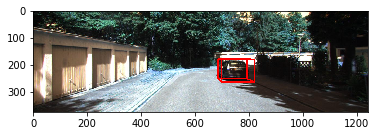

In [0]:
draw_3D_box(resized_result, left_img, left_car_top_left, left_car_bottom_right, 3)

# Q3.a

In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 349kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 105.5MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
def bad_points(top_eight, d):
    bad = []
    for item in top_eight:
        distance_list = []
        index = top_eight.index(item)
        for i in range(len(top_eight)):
            if i != index:
                distance = np.sum(np.array(item[0][0].pt) - np.array(top_eight[i][0][0].pt))**2
                # print("for #", index, " point, the distance with #", i, " = ", distance)
                distance_list.append(distance)
        for dis in distance_list:
            if dis < d:
                bad.append(item)
                break
                # print("bad point = ", item)
    return bad

def remove_bad_points(top_eight, bad_points):
    if bad_points is False:
        return top_eight

    for item in bad_points:
        top_eight.remove(item)
    return top_eight   

def best_eight_with_distance(top_eight, sorted_keypointes, d):
    # print("num of points = ", len(top_eight))
    index = 8
    bad_points_list = bad_points(top_eight, d)

    if bad_points_list is False:
        return top_eight

    else:
        rest_points_list = remove_bad_points(top_eight, bad_points_list)

    while bad_points_list:

        # print("num of rest points = ", len(rest_points_list))
        num_of_new_points = len(bad_points_list)
        # print("num of bad and new points = ", len(bad_points_list))

        for i in range(index, index + num_of_new_points):
            # print("index = ", i)
            rest_points_list.append(sorted_keypointes[i])
        
        index = index + num_of_new_points
        # print("next index = ", index)
        bad_points_list = bad_points(rest_points_list, d)
        # print("next num of bad and new points = ", len(bad_points_list))
        rest_points_list = remove_bad_points(rest_points_list, bad_points_list)
        # print("next num of rest points = ", len(rest_points_list))
        # print("===============================================================")

    return rest_points_list
    
def sift_extract(image, resize):
    img = cv2.imread(image)
    img = cv2.resize(img, (int(resize*img.shape[1]),int(resize*img.shape[0])))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sift = cv2.xfeatures2d.SIFT_create(2000)

    keypoints, features = sift.detectAndCompute(gray_img, None)
    result = cv2.drawKeypoints(gray_img, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, outImage=None)

    # cv2.imwrite('sift_keypoints.jpg', result)
    return keypoints, features

def sift_matching(image1, image2, ratio_threshold, norm_level, d, resize):
    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)
    img1 = cv2.resize(img1, (int(resize*img1.shape[1]),int(resize*img1.shape[0])))
    img2 = cv2.resize(img2, (int(resize*img2.shape[1]),int(resize*img2.shape[0])))
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    kp_1, des_1 = sift_extract(image1, resize)
    kp_2, des_2 = sift_extract(image2, resize)
    num_des_1 = np.shape(des_1)[0]
    num_des_2 = np.shape(des_2)[0]
    num_matching_keypoint = num_des_1

    candidate_keypoint_location = []
    candidate_distance = []

    for i in range(num_des_1):
        distance = []
        for j in range(num_des_2):
            euclidean_dis = euclidean_distance(des_1[i], des_2[j], norm_level)
            distance.append(euclidean_dis)
        two_smallest_distance = heapq.nsmallest(2, distance)
        candidate_distance.append(two_smallest_distance)
        np_distance = np.array(distance)
        min_dis_index = np.unravel_index(np.argmin(np_distance, axis=None), np_distance.shape)[0]
        candidate_keypoint_location.append(min_dis_index)

    keypoint1 = []
    keypoint2 = []
    keypoints_pairs = {}
    count = 0

    for i in range(num_matching_keypoint):
        ratio = np.true_divide(candidate_distance[i][0], candidate_distance[i][1])
        if ratio < ratio_threshold:
            count = count + 1
            kp1 = kp_1[i]
            kp2 = kp_2[candidate_keypoint_location[i]]
            keypoint1.append(kp1)
            keypoint2.append(kp2)
            keypoints_pairs[(kp1,kp2)] = ratio

    sorted_keypointes = sorted(keypoints_pairs.items(), key=lambda kv: kv[1])

    print("number of matching = ", count)

    top_eight = sorted_keypointes[0:8]
    print("top eight = ", top_eight)

    best_eight = best_eight_with_distance(top_eight, sorted_keypointes, d)

    print("best eight = ", best_eight)

    result_img1 = cv2.drawKeypoints(gray1, keypoint1, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    result_img2 = cv2.drawKeypoints(gray2, keypoint2, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.imwrite("sample1_keypoints_final.jpg", result_img1)
    cv2.imwrite("sample2_keypoints_final.jpg", result_img2)
    # show_matching(gray1, keypoint1, gray2, keypoint2)

    return best_eight

def euclidean_distance(vector1, vector2, norm_level):
    vector1 = vector1.reshape(-1)
    vector2 = vector2.reshape(-1)
    distance = np.linalg.norm(vector1 - vector2, ord=norm_level)
    return distance

def show_matching(image1, keypoint1, image2, keypoint2):
    plt.figure(figsize=(24,64))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    img1 = cv2.drawKeypoints(image1, keypoint1, None)
    img2 = cv2.drawKeypoints(image2, keypoint2, None)

    ax1.imshow(img1)
    ax2.imshow(img2)

    colors = ["white", "red", "blue", "orange", "pink", "yellow", "violet", "green"]
    color_i = 0
    for kp1, kp2 in zip(keypoint1, keypoint2):
        coord1 = kp1.pt
        coord2 = kp2.pt
        c = colors[color_i % 8]
        con = ConnectionPatch(xyA=coord2, xyB=coord1, coordsA="data", coordsB="data", axesA=ax2, axesB=ax1, arrowstyle="-", color=c)
        ax2.add_patch(con)
        color_i += 1

    plt.show()
    

def generate_top_eight_color(image1, image2, top, resize):
    img1 = cv2.imread(image1, cv2.IMREAD_COLOR)
    img2 = cv2.imread(image2, cv2.IMREAD_COLOR)
    img1 = cv2.resize(img1, (int(resize*img1.shape[1]),int(resize*img1.shape[0])))
    img2 = cv2.resize(img2, (int(resize*img2.shape[1]),int(resize*img2.shape[0])))
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
   
    keypoint1 = []
    keypoint2 = []

    for item in top:
        keypoint1.append(item[0][0])
        keypoint2.append(item[0][1])

    show_matching(img1, keypoint1, img2, keypoint2)

number of matching =  1369
top eight =  [((<KeyPoint 0x7f67563ff270>, <KeyPoint 0x7f6756428780>), 0.049495086), ((<KeyPoint 0x7f6756433600>, <KeyPoint 0x7f6756423ed0>), 0.06686851), ((<KeyPoint 0x7f67563ff240>, <KeyPoint 0x7f6756428660>), 0.07845982), ((<KeyPoint 0x7f6756467cf0>, <KeyPoint 0x7f6756422300>), 0.07881482), ((<KeyPoint 0x7f67563fd2a0>, <KeyPoint 0x7f67563b6bd0>), 0.07904964), ((<KeyPoint 0x7f675640f810>, <KeyPoint 0x7f67563b57b0>), 0.079522155), ((<KeyPoint 0x7f6756467240>, <KeyPoint 0x7f67563fed20>), 0.08199431), ((<KeyPoint 0x7f67564337e0>, <KeyPoint 0x7f6756419ae0>), 0.08643514)]
best eight =  [((<KeyPoint 0x7f6756467bd0>, <KeyPoint 0x7f67563b50f0>), 0.11567957), ((<KeyPoint 0x7f67564655a0>, <KeyPoint 0x7f6756428300>), 0.13859838), ((<KeyPoint 0x7f675640de10>, <KeyPoint 0x7f67564178d0>), 0.13958311), ((<KeyPoint 0x7f67564324b0>, <KeyPoint 0x7f6756414660>), 0.14201508), ((<KeyPoint 0x7f6756427ab0>, <KeyPoint 0x7f6756406480>), 0.14302622), ((<KeyPoint 0x7f675642e2a0>, <Ke

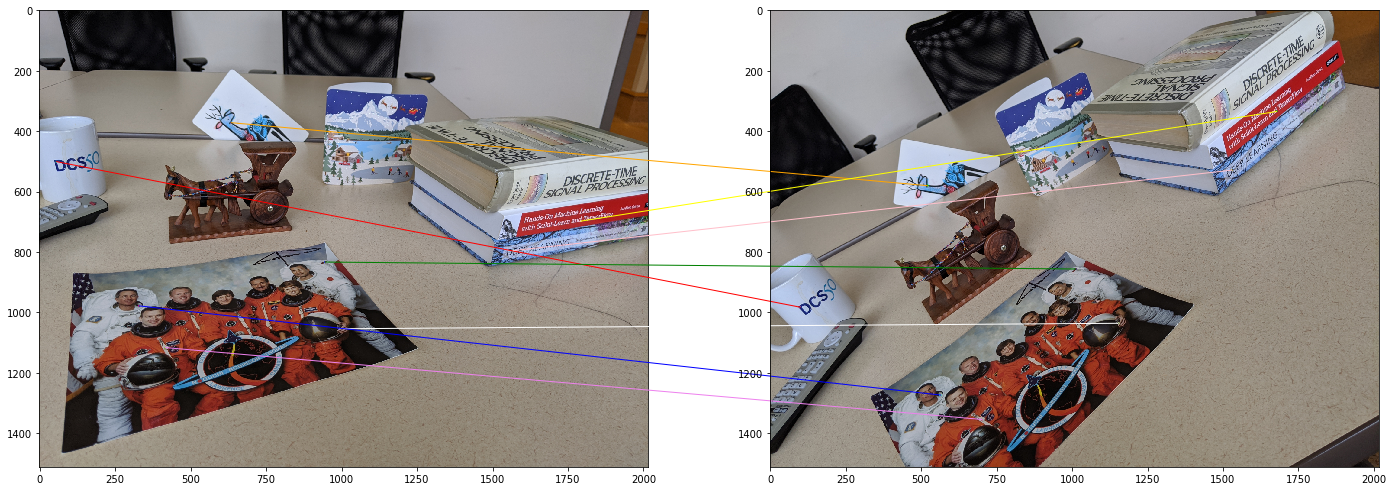

In [0]:
top_eight_i1i2 = sift_matching(I1_path, I2_path, 0.8, 2, 15205, 0.5)
print(len(top_eight_i1i2))
generate_top_eight_color(I1_path, I2_path, top_eight_i1i2, 0.5)

number of matching =  242
top eight =  [((<KeyPoint 0x7f6753b73e10>, <KeyPoint 0x7f67427db240>), 0.1732607), ((<KeyPoint 0x7f6756428390>, <KeyPoint 0x7f67427db3f0>), 0.23626941), ((<KeyPoint 0x7f6756467690>, <KeyPoint 0x7f6742804120>), 0.24046822), ((<KeyPoint 0x7f6756411300>, <KeyPoint 0x7f67427e48a0>), 0.24355675), ((<KeyPoint 0x7f67564116c0>, <KeyPoint 0x7f67427e48d0>), 0.2488239), ((<KeyPoint 0x7f6753b73210>, <KeyPoint 0x7f674280dde0>), 0.28966612), ((<KeyPoint 0x7f6753b0d9f0>, <KeyPoint 0x7f67427e4120>), 0.30243275), ((<KeyPoint 0x7f67ac3b4b70>, <KeyPoint 0x7f674280d960>), 0.30358016)]
best eight =  [((<KeyPoint 0x7f6753b09db0>, <KeyPoint 0x7f6742802c00>), 0.31989396), ((<KeyPoint 0x7f6756465b10>, <KeyPoint 0x7f674280db40>), 0.6572044), ((<KeyPoint 0x7f67427d7300>, <KeyPoint 0x7f67427fa180>), 0.6705068), ((<KeyPoint 0x7f6753b0d810>, <KeyPoint 0x7f67427fce70>), 0.67864895), ((<KeyPoint 0x7f6753b73030>, <KeyPoint 0x7f674280dd20>), 0.68097425), ((<KeyPoint 0x7f67427d4240>, <KeyPoint 

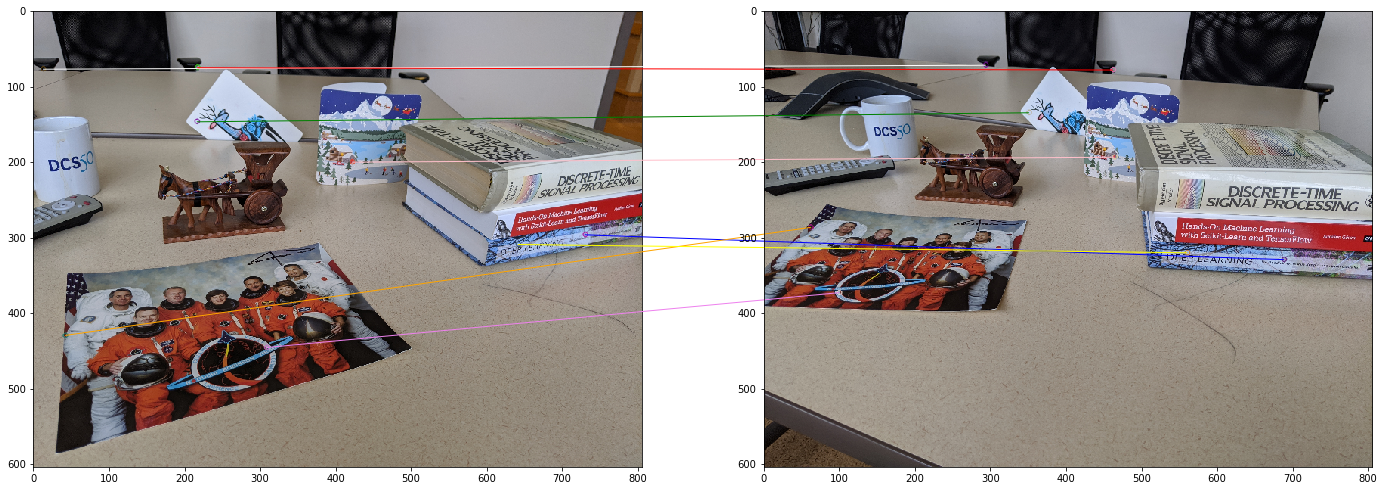

In [0]:
top_eight_i1i3 = sift_matching(I1_path, I3_path, 0.8, 2, 5000, 0.2)
print(len(top_eight_i1i3))
generate_top_eight_color(I1_path, I3_path, top_eight_i1i3, 0.2)

# Q3.b

In [0]:
m2 = []
for item in top_eight_i1i2:
    m2.append((item[0][0].pt,item[0][1].pt))
m2 = np.array(m2)

m3 = []
for item in top_eight_i1i3:
    m3.append((item[0][0].pt,item[0][1].pt))
m3 = np.array(m3)

print("m2 = ", m2)
print("============================================")
print("m3 = ", m3)
print("============================================")

m2_left = []
for item in m2:
    m2_left.append(item[0])
m2_left = np.array(m2_left)

m2_right = []
for item in m2:
    m2_right.append(item[1])
m2_right = np.array(m2_right)

print("m2_left = ", m2_left)
print("============================================")
print("m2_right = ", m2_right)
print("============================================")

m3_left = []
for item in m3:
    m3_left.append(item[0])
m3_left = np.array(m3_left)

m3_right = []
for item in m3:
    m3_right.append(item[1])
m3_right = np.array(m3_right)

print("m3_left = ", m3_left)
print("============================================")
print("m3_right = ", m3_right)
print("============================================")

m2_left_x = []
for item in m2_left:
    m2_left_x.append(item[0])
m2_left_x = np.array(m2_left_x)

m2_left_y = []
for item in m2_left:
    m2_left_y.append(item[1])
m2_left_y = np.array(m2_left_y)

print("m2_left_x = ", m2_left_x)
print("============================================")
print("m2_left_y = ", m2_left_y)
print("============================================")

m2_right_x = []
for item in m2_right:
    m2_right_x.append(item[0])
m2_right_x = np.array(m2_right_x)

m2_right_y = []
for item in m2_right:
    m2_right_y.append(item[1])
m2_right_y = np.array(m2_right_y)

print("m2_right_x = ", m2_right_x)
print("============================================")
print("m2_right_y = ", m2_right_y)
print("============================================")

m3_left_x = []
for item in m3_left:
    m3_left_x.append(item[0])
m3_left_x = np.array(m3_left_x)

m3_left_y = []
for item in m3_left:
    m3_left_y.append(item[1])
m3_left_y = np.array(m3_left_y)

print("m3_left_x = ", m3_left_x)
print("============================================")
print("m3_left_y = ", m3_left_y)
print("============================================")

m3_right_x = []
for item in m3_right:
    m3_right_x.append(item[0])
m3_right_x = np.array(m3_right_x)

m3_right_y = []
for item in m3_right:
    m3_right_y.append(item[1])
m3_right_y = np.array(m3_right_y)

print("m3_right_x = ", m3_right_x)
print("============================================")
print("m3_right_y = ", m3_right_y)
print("============================================")


def generate_F(m_left_x, m_left_y, m_right_x, m_right_y):

    a = [m_left_x * m_right_x, m_left_y * m_right_x, m_right_x,
         m_left_x * m_right_y, m_left_y * m_right_y, m_right_y,
         m_left_x, m_left_y, 1]

    A = np.zeros((8, 9))

    for i in range(9):
        A[:, i] = a[i]

    u, s, vh = np.linalg.svd(A)
    U, D, VT = np.linalg.svd(vh[-1].reshape(3,3))
    D[-1] = 0

    F = np.dot(np.dot(U, np.diag(D)), VT)

    return F

F2 = generate_F(m2_left_x, m2_left_y, m2_right_x, m2_right_y)
F3 = generate_F(m3_left_x, m3_left_y, m3_right_x, m3_right_y)

print("F_12 for I1 and I2 = ", F2)
print("F_13 for I1 and I3 = ", F3)

m2 =  [[[ 992.64160156 1054.36523438]
  [1152.92810059 1036.20275879]]

 [[  55.89989471  500.80358887]
  [  99.48069     982.84503174]]

 [[ 330.92382812  978.65759277]
  [ 563.63586426 1273.72851562]]

 [[ 635.06542969  371.865448  ]
  [ 520.93902588  580.41455078]]

 [[1568.9519043   795.54559326]
  [1527.81848145  529.26617432]]

 [[1792.41125488  697.9342041 ]
  [1677.46569824  334.81274414]]

 [[ 417.07644653 1116.72094727]
  [ 701.20178223 1354.70043945]]

 [[ 947.23052979  833.40350342]
  [1010.97283936  856.42010498]]]
m3 =  [[[ 13.26263428  77.05036163]
  [293.13308716  71.75640106]]

 [[217.43736267  75.0866394 ]
  [461.55490112  78.15990448]]

 [[730.6307373  296.32421875]
  [688.04431152 329.1963501 ]]

 [[ 42.50888062 429.51495361]
  [ 61.64493179 286.46450806]]

 [[422.22662354 200.1441803 ]
  [463.72546387 193.59814453]]

 [[641.93103027 309.12567139]
  [560.02832031 320.13165283]]

 [[309.08981323 445.58282471]
  [ 99.3062439  372.94580078]]

 [[216.87513733 146.713821

# Q3.c

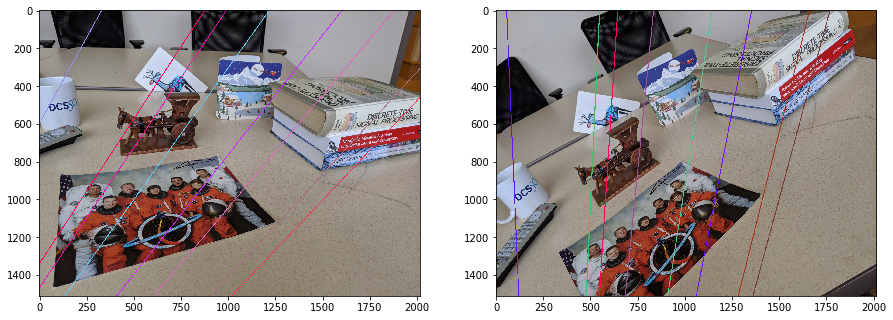

(array([[[157, 152, 158],
         [156, 151, 157],
         [160, 155, 161],
         ...,
         [ 94,  56,  19],
         [ 92,  54,  18],
         [ 93,  55,  19]],
 
        [[157, 152, 158],
         [156, 151, 157],
         [160, 155, 161],
         ...,
         [ 92,  54,  17],
         [ 95,  57,  21],
         [ 93,  55,  19]],
 
        [[160, 155, 161],
         [159, 154, 161],
         [160, 155, 162],
         ...,
         [ 94,  56,  19],
         [ 92,  54,  18],
         [ 93,  55,  19]],
 
        ...,
 
        [[158, 147, 127],
         [159, 148, 130],
         [158, 147, 129],
         ...,
         [138, 135, 120],
         [135, 132, 117],
         [139, 136, 119]],
 
        [[159, 148, 128],
         [161, 150, 130],
         [158, 147, 129],
         ...,
         [134, 131, 116],
         [134, 131, 114],
         [133, 130, 113]],
 
        [[159, 148, 128],
         [158, 147, 127],
         [157, 146, 126],
         ...,
         [137, 134, 117],
  

In [0]:
def drawlines(img1, lines):
    r = img1.shape[0]
    c = img1.shape[1]

    for r in lines:
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1]])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img3 = cv2.line(img1, (x0,y0), (x1,y1), color, 3)

    return img3

def epipolarline(img1_path, img2_path, kp1, kp2, F, resize):
    img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
    img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)
    img1 = cv2.resize(img1, (int(resize*img1.shape[1]),int(resize*img1.shape[0])))
    img2 = cv2.resize(img2, (int(resize*img2.shape[1]),int(resize*img2.shape[0])))
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    points1 = np.int32(kp1)
    points2 = np.int32(kp2)

    lines1 = cv2.computeCorrespondEpilines(points2.reshape(-1,1,2),2,F)
    lines1 = lines1.reshape(-1,3)
    img1 = drawlines(img1, lines1)

    lines2 = cv2.computeCorrespondEpilines(points1.reshape(-1,1,2),1,F)
    lines2 = lines2.reshape(-1,3)
    img2 = drawlines(img2, lines2)

    fig = plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1),plt.imshow(img1)
    plt.subplot(1,2,2),plt.imshow(img2)
    plt.show()

    return img1, img2

epipolarline(I1_path, I2_path, m2_left, m2_right, F2, 0.5)

# Q3.d

In [0]:
resize_2 = 0.5
resize_3 = 0.2
col_2 = int(resize_2*I1_img.shape[1])
row_2 = int(resize_2*I1_img.shape[0])
col_3 = int(resize_3*I1_img.shape[1])
row_3 = int(resize_3*I1_img.shape[0])

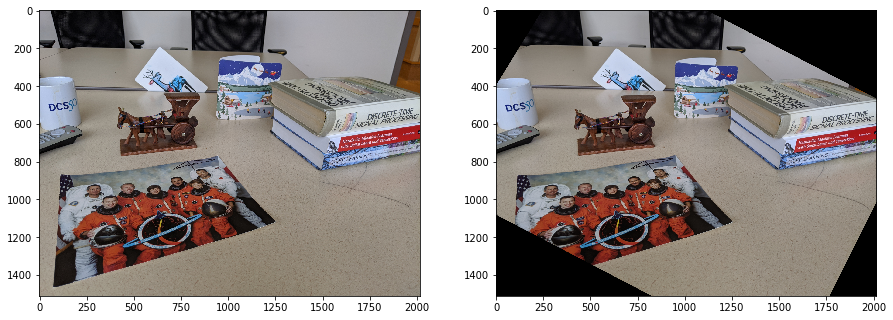

In [0]:
_, H2_left, H2_right = cv2.stereoRectifyUncalibrated(m2_left, m2_right, F2, (col_2, row_2))

H2_new = np.linalg.inv(H2_left).dot(H2_right)

rec2_right = cv2.warpPerspective(I2_img_resized, H2_new, (col_2, row_2))

fig = plt.figure(figsize=(15, 30))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(I1_img_resized)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(rec2_right)
plt.show()

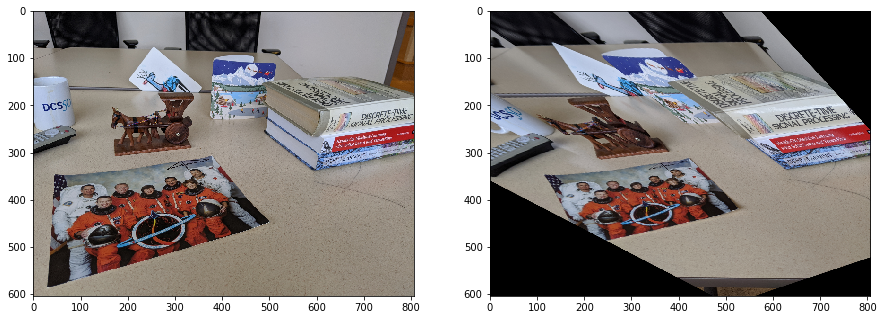

In [0]:
_, H3_left, H3_right = cv2.stereoRectifyUncalibrated(m3_left, m3_right, F3, (col_3, row_3))

H3_new = np.linalg.inv(H3_left).dot(H3_right)

rec3_right = cv2.warpPerspective(I3_img_resized, H3_new, (col_3, row_3))

fig = plt.figure(figsize=(15, 30))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(I1_img_resized_3)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(rec3_right)
plt.show()

# Q3.e

In [0]:
def cv2_F(m_left, m_right):
    F, mask = cv2.findFundamentalMat(np.int32(m_left),np.int32(m_right),cv2.FM_8POINT)
    return F

F2_prime = cv2_F(m2_left, m2_right)
F3_prime = cv2_F(m3_left, m3_right)

print("F_12 prime = ", F2_prime)
print("F_13 prime = ", F3_prime)

F_12 prime =  [[ 2.25324436e-07 -5.31586029e-07  1.06922119e-02]
 [ 7.78711153e-07  6.06811768e-07  2.13927053e-03]
 [-8.19916954e-03 -8.04072290e-03  1.00000000e+00]]
F_13 prime =  [[ 1.20394471e-06  4.82397810e-06 -2.37948066e-03]
 [-3.30851062e-06  8.98631879e-06 -5.22083256e-03]
 [ 1.53013774e-03 -1.48049222e-03  1.00000000e+00]]


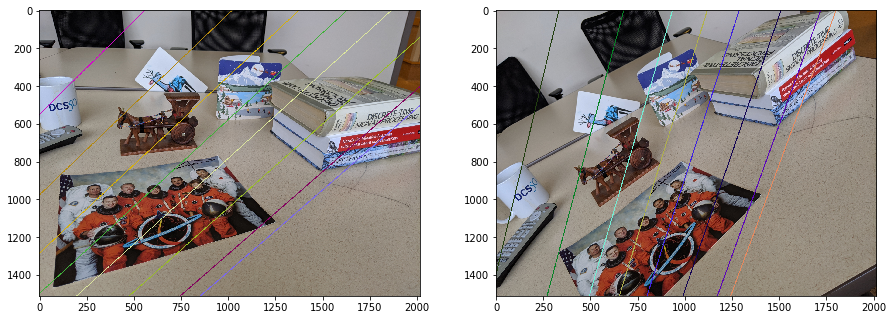

(array([[[157, 152, 158],
         [156, 151, 157],
         [160, 155, 161],
         ...,
         [ 94,  56,  19],
         [ 92,  54,  18],
         [ 93,  55,  19]],
 
        [[157, 152, 158],
         [156, 151, 157],
         [160, 155, 161],
         ...,
         [ 92,  54,  17],
         [ 95,  57,  21],
         [ 93,  55,  19]],
 
        [[160, 155, 161],
         [159, 154, 161],
         [160, 155, 162],
         ...,
         [ 94,  56,  19],
         [ 92,  54,  18],
         [ 93,  55,  19]],
 
        ...,
 
        [[158, 147, 127],
         [159, 148, 130],
         [158, 147, 129],
         ...,
         [138, 135, 120],
         [135, 132, 117],
         [139, 136, 119]],
 
        [[159, 148, 128],
         [161, 150, 130],
         [158, 147, 129],
         ...,
         [134, 131, 116],
         [134, 131, 114],
         [133, 130, 113]],
 
        [[159, 148, 128],
         [158, 147, 127],
         [157, 146, 126],
         ...,
         [137, 134, 117],
  

In [0]:
epipolarline(I1_path, I2_path, m2_left, m2_right, F2_prime, 0.5)

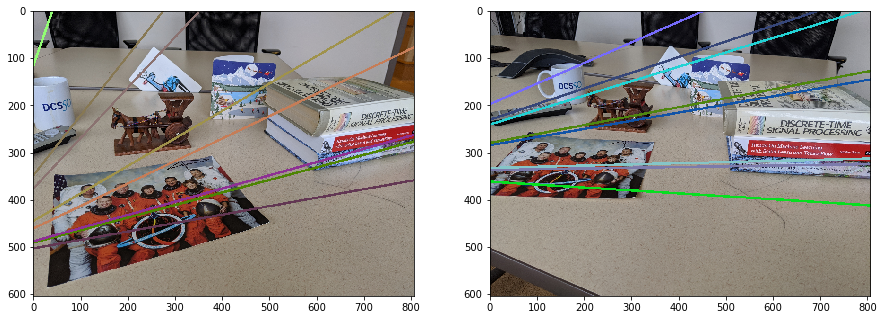

(array([[[153, 148, 154],
         [157, 152, 159],
         [157, 154, 163],
         ...,
         [ 91,  53,  16],
         [ 94,  56,  19],
         [ 95,  57,  21]],
 
        [[157, 152, 159],
         [155, 152, 159],
         [157, 154, 163],
         ...,
         [ 92,  57,  19],
         [ 89,  51,  14],
         [ 95,  57,  20]],
 
        [[158, 155, 164],
         [154, 151, 160],
         [157, 154, 163],
         ...,
         [ 92,  56,  20],
         [ 94,  56,  19],
         [ 93,  55,  18]],
 
        ...,
 
        [[163, 151, 137],
         [158, 149, 134],
         [157, 148, 133],
         ...,
         [135, 129, 117],
         [139, 131, 118],
         [132, 124, 111]],
 
        [[160, 149, 131],
         [159, 147, 131],
         [157, 145, 129],
         ...,
         [138, 132, 118],
         [137, 131, 117],
         [138, 132, 118]],
 
        [[161, 150, 130],
         [159, 148, 130],
         [159, 147, 131],
         ...,
         [143, 137, 123],
  

In [0]:
epipolarline(I1_path, I3_path, m3_left, m3_right, F3_prime, 0.2)

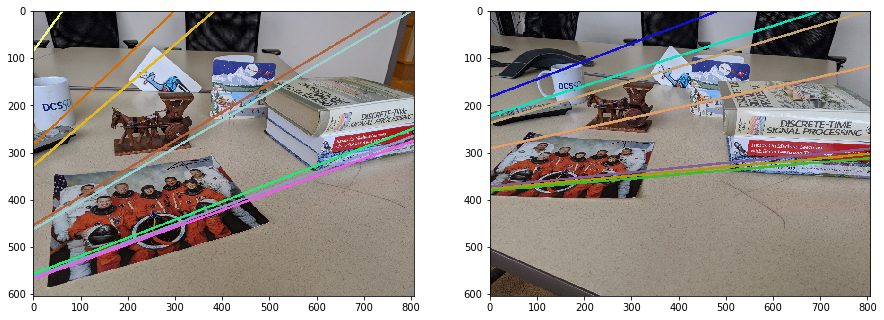

(array([[[153, 148, 154],
         [157, 152, 159],
         [157, 154, 163],
         ...,
         [153, 208, 205],
         [153, 208, 205],
         [153, 208, 205]],
 
        [[157, 152, 159],
         [155, 152, 159],
         [157, 154, 163],
         ...,
         [153, 208, 205],
         [153, 208, 205],
         [153, 208, 205]],
 
        [[158, 155, 164],
         [154, 151, 160],
         [157, 154, 163],
         ...,
         [153, 208, 205],
         [153, 208, 205],
         [ 93,  55,  18]],
 
        ...,
 
        [[163, 151, 137],
         [158, 149, 134],
         [157, 148, 133],
         ...,
         [135, 129, 117],
         [139, 131, 118],
         [132, 124, 111]],
 
        [[160, 149, 131],
         [159, 147, 131],
         [157, 145, 129],
         ...,
         [138, 132, 118],
         [137, 131, 117],
         [138, 132, 118]],
 
        [[161, 150, 130],
         [159, 148, 130],
         [159, 147, 131],
         ...,
         [143, 137, 123],
  

In [0]:
epipolarline(I1_path, I3_path, m3_left, m3_right, F3, 0.2)

# Q3.f

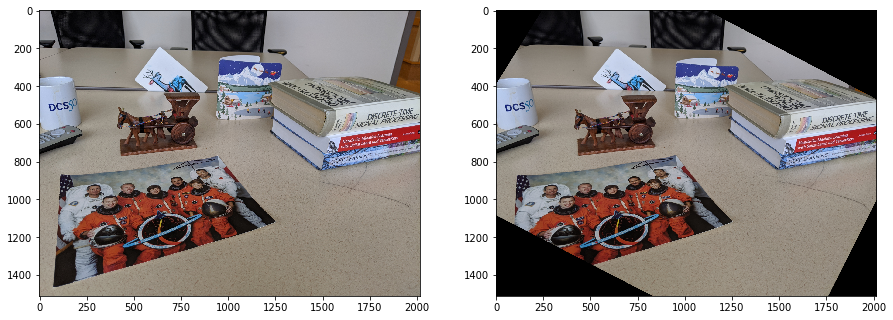

In [0]:
_, H2_left_prime, H2_right_prime = cv2.stereoRectifyUncalibrated(m2_left, m2_right, F2_prime, (col_2, row_2))

H2_prime_new = np.linalg.inv(H2_left_prime).dot(H2_right_prime)

rec2_right_prime = cv2.warpPerspective(I2_img_resized, H2_prime_new, (col_2, row_2))

fig = plt.figure(figsize=(15, 30))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(I1_img_resized)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(rec2_right_prime)
plt.show()

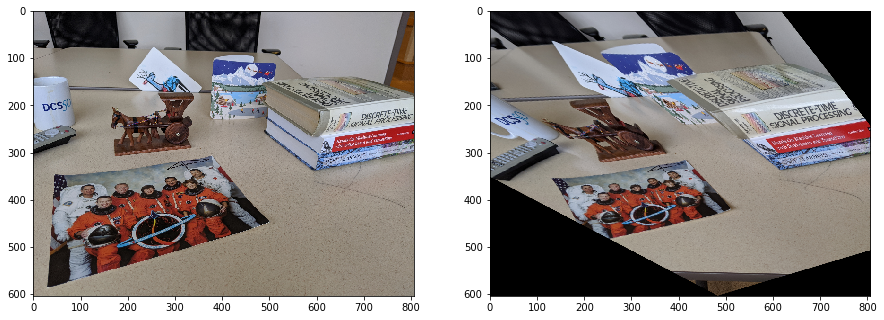

In [0]:
_, H3_left_prime, H3_right_prime = cv2.stereoRectifyUncalibrated(m3_left, m3_right, F3_prime, (col_3, row_3))

H3_prime_new = np.linalg.inv(H3_left_prime).dot(H3_right_prime)

rec3_left_prime = cv2.warpPerspective(I3_img_resized, H3_prime_new, (col_3, row_3))
fig = plt.figure(figsize=(15, 30))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(I1_img_resized_3)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(rec3_left_prime)
plt.show()